# **Bibliotecas**

In [1]:
%%capture

!pip install shap
!pip install optuna

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [5]:
# Leitura dos dados de pele
df_pele = pd.read_csv('pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


In [6]:
# Valores faltantes
df_pele.isna().sum().sort_values(ascending=False).head(6)

DRS               1
IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
dtype: int64

In [7]:
df_pele.dropna(inplace=True)
df_pele.shape

(183163, 32)

In [8]:
df_pele_ano5 = df_pele[~((df_pele.obito_geral == 0) & (df_pele.sobrevida_ano5 == 0))].reset_index(drop=True)
df_pele_ano5.shape

(83655, 32)

In [9]:
# Correlação com a saída
corr_matrix = df_pele_ano5.corr()
abs(corr_matrix['sobrevida_ano5']).sort_values(ascending=False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano5      1.000000
sobrevida_ano3      0.757795
obito_geral         0.614901
sobrevida_ano1      0.403770
IDADE               0.317771
ANODIAG             0.228551
ESCOLARI_preench    0.118032
QUIMIO              0.112154
DIAGTRAT            0.069277
TRATCONS            0.068917
NENHUM              0.068619
CIRURGIA            0.067601
presenca_rec        0.060008
CATEATEND           0.057672
RADIO               0.053509
SEXO                0.040492
HABILIT2            0.040083
DIAGPREV            0.039246
OUTROS              0.031173
DRS                 0.024462
Name: sobrevida_ano5, dtype: float64

In [10]:
# Quantidade de pacientes em cada classe da saída
df_pele_ano5.sobrevida_ano5.value_counts()

1    50446
0    33209
Name: sobrevida_ano5, dtype: int64

## **Pré-processamento**

In [11]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano3']

lb = 'sobrevida_ano5'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pele_ano5,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (62741, 25), X_test = (20914, 25)
y_train = (62741,), y_test = (20914,)


In [12]:
y_train.value_counts(normalize=True)

1    0.603019
0    0.396981
Name: sobrevida_ano5, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

1    0.603041
0    0.396959
Name: sobrevida_ano5, dtype: float64

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo base**

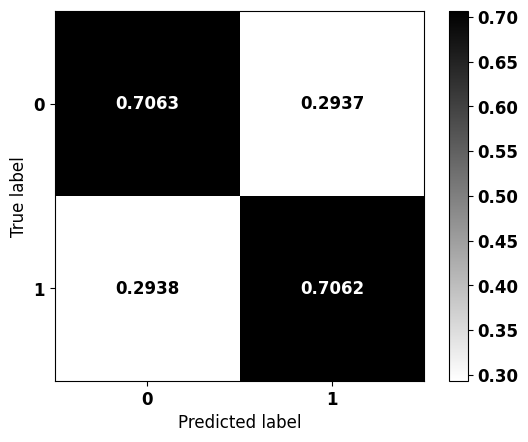


              precision    recall  f1-score   support

           0     0.6128    0.7063    0.6563      8302
           1     0.7851    0.7062    0.7436     12612

    accuracy                         0.7063     20914
   macro avg     0.6990    0.7063    0.6999     20914
weighted avg     0.7167    0.7063    0.7089     20914



In [31]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:1.706, 1:1},
                            max_depth=10,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

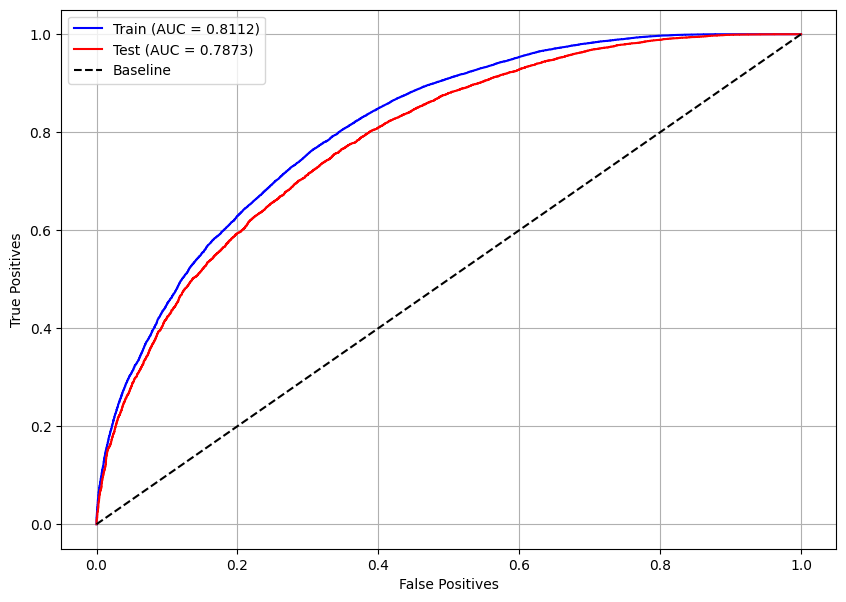

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

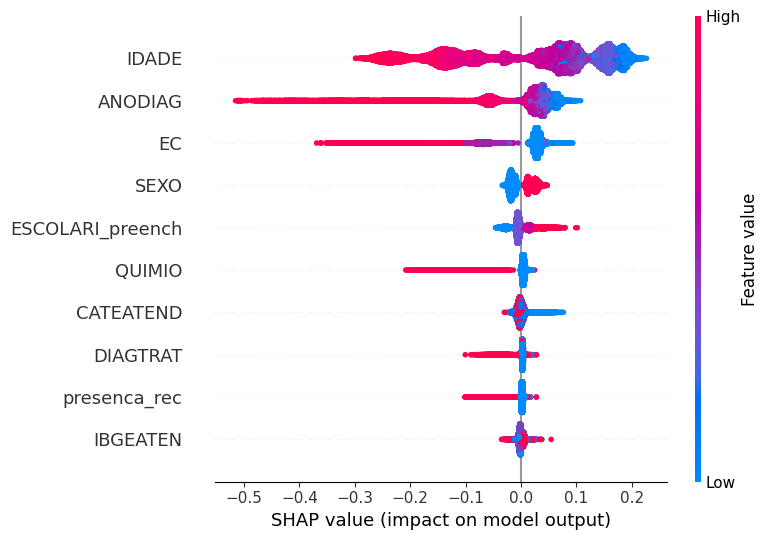

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=79, state=TrialState.COMPLETE, values=[0.736328778605692], datetime_start=datetime.datetime(2023, 10, 16, 13, 5, 19, 340991), datetime_complete=datetime.datetime(2023, 10, 16, 13, 6, 49, 129532), params={'n_estimators': 131, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.7, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=79, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 131,
 'max_depth': 10,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_samples': 0.7,
 'criterion': 'gini'}

1.688


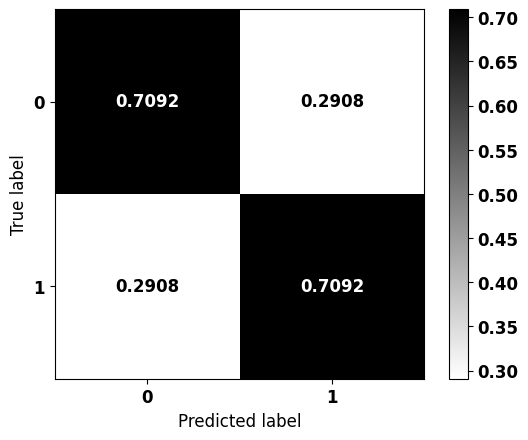


              precision    recall  f1-score   support

           0     0.6162    0.7092    0.6594      8302
           1     0.7875    0.7092    0.7463     12612

    accuracy                         0.7092     20914
   macro avg     0.7018    0.7092    0.7028     20914
weighted avg     0.7195    0.7092    0.7118     20914


1.693


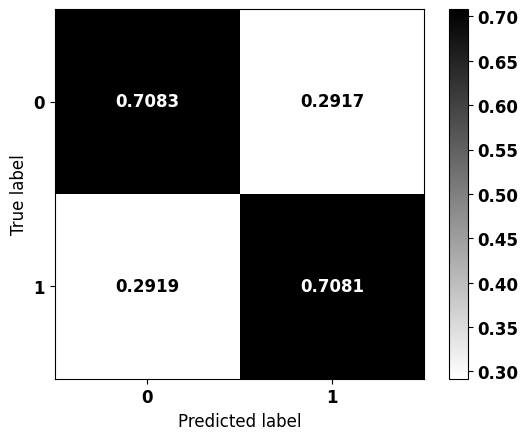


              precision    recall  f1-score   support

           0     0.6150    0.7083    0.6583      8302
           1     0.7867    0.7081    0.7453     12612

    accuracy                         0.7082     20914
   macro avg     0.7008    0.7082    0.7018     20914
weighted avg     0.7185    0.7082    0.7108     20914


1.697


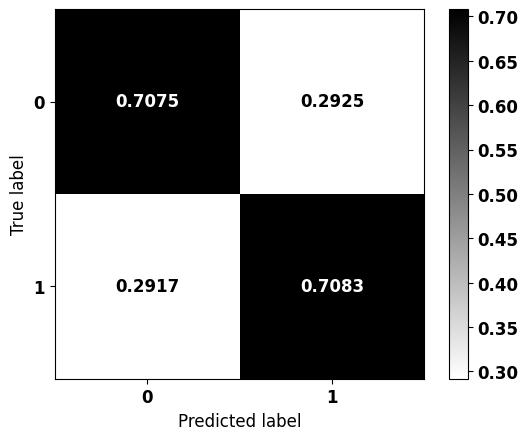


              precision    recall  f1-score   support

           0     0.6149    0.7075    0.6580      8302
           1     0.7863    0.7083    0.7453     12612

    accuracy                         0.7080     20914
   macro avg     0.7006    0.7079    0.7016     20914
weighted avg     0.7182    0.7080    0.7106     20914


1.702


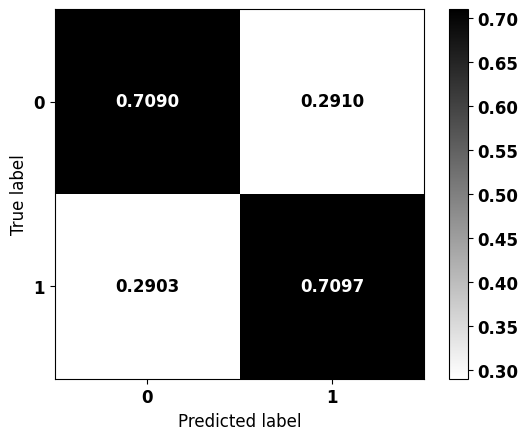


              precision    recall  f1-score   support

           0     0.6165    0.7090    0.6595      8302
           1     0.7875    0.7097    0.7466     12612

    accuracy                         0.7094     20914
   macro avg     0.7020    0.7094    0.7031     20914
weighted avg     0.7196    0.7094    0.7120     20914


1.704


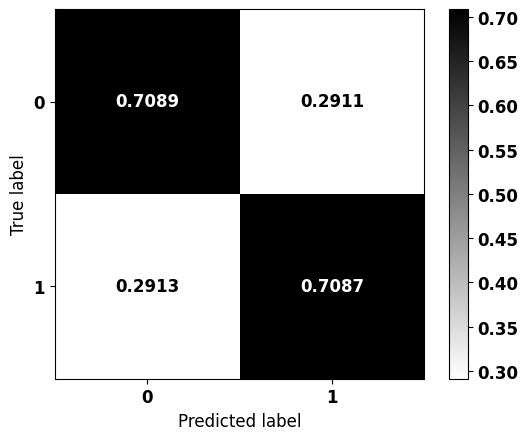


              precision    recall  f1-score   support

           0     0.6157    0.7089    0.6590      8302
           1     0.7871    0.7087    0.7459     12612

    accuracy                         0.7088     20914
   macro avg     0.7014    0.7088    0.7024     20914
weighted avg     0.7191    0.7088    0.7114     20914


1.708


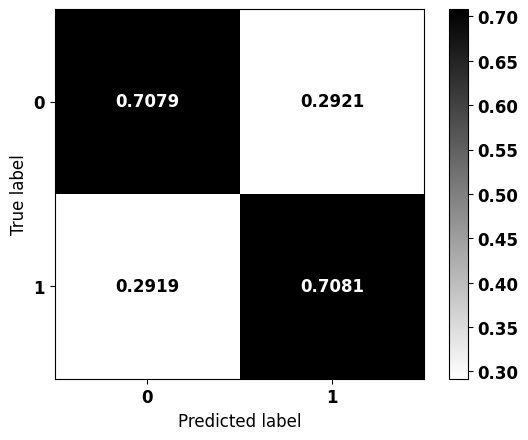


              precision    recall  f1-score   support

           0     0.6149    0.7079    0.6581      8302
           1     0.7865    0.7081    0.7452     12612

    accuracy                         0.7080     20914
   macro avg     0.7007    0.7080    0.7017     20914
weighted avg     0.7183    0.7080    0.7107     20914


1.709


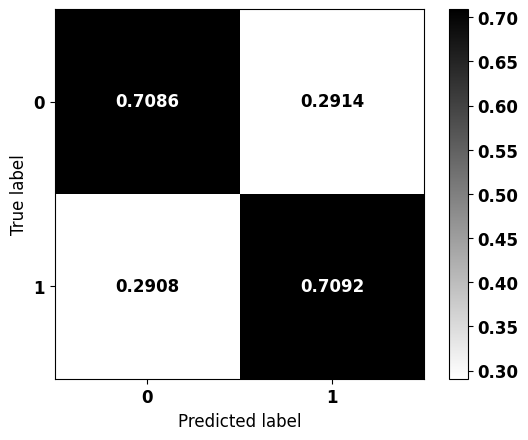


              precision    recall  f1-score   support

           0     0.6160    0.7086    0.6591      8302
           1     0.7871    0.7092    0.7462     12612

    accuracy                         0.7090     20914
   macro avg     0.7016    0.7089    0.7026     20914
weighted avg     0.7192    0.7090    0.7116     20914




In [ ]:
pesos = np.round(np.arange(1.6, 1.8, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.7, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 144,
 'max_depth': 10,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_samples': 0.8999999999999999,
 'criterion': 'entropy'}

1.716


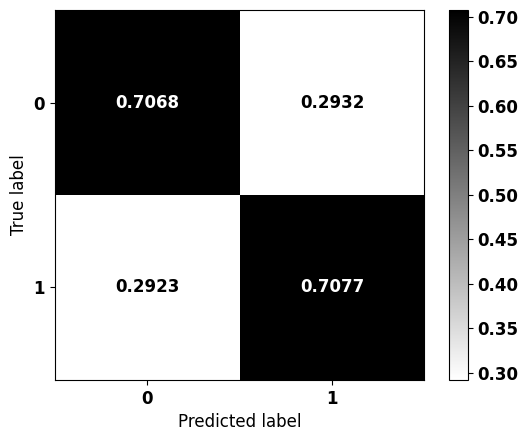


              precision    recall  f1-score   support

           0     0.6141    0.7068    0.6572      8302
           1     0.7857    0.7077    0.7446     12612

    accuracy                         0.7073     20914
   macro avg     0.6999    0.7072    0.7009     20914
weighted avg     0.7176    0.7073    0.7099     20914


1.717


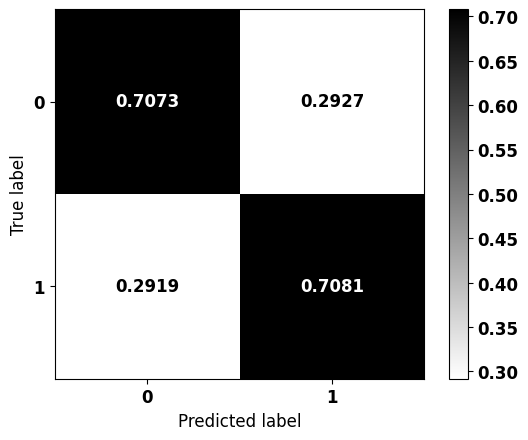


              precision    recall  f1-score   support

           0     0.6147    0.7073    0.6577      8302
           1     0.7861    0.7081    0.7451     12612

    accuracy                         0.7078     20914
   macro avg     0.7004    0.7077    0.7014     20914
weighted avg     0.7181    0.7078    0.7104     20914


1.719


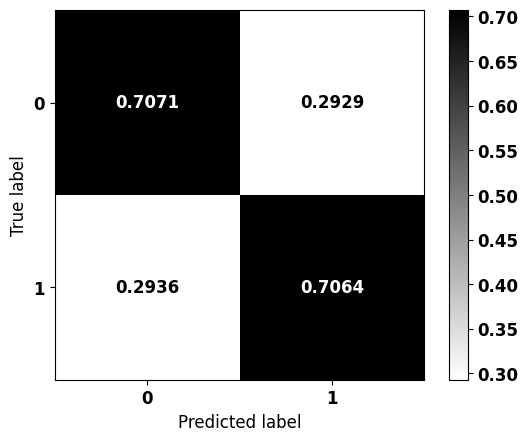


              precision    recall  f1-score   support

           0     0.6132    0.7071    0.6568      8302
           1     0.7856    0.7064    0.7439     12612

    accuracy                         0.7067     20914
   macro avg     0.6994    0.7067    0.7003     20914
weighted avg     0.7171    0.7067    0.7093     20914


1.723


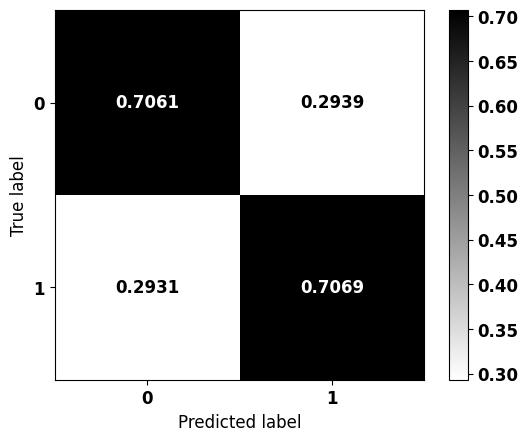


              precision    recall  f1-score   support

           0     0.6132    0.7061    0.6564      8302
           1     0.7851    0.7069    0.7439     12612

    accuracy                         0.7066     20914
   macro avg     0.6992    0.7065    0.7002     20914
weighted avg     0.7169    0.7066    0.7092     20914


1.726


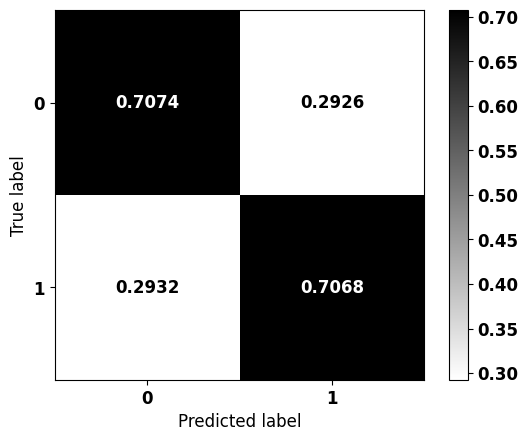


              precision    recall  f1-score   support

           0     0.6136    0.7074    0.6572      8302
           1     0.7859    0.7068    0.7442     12612

    accuracy                         0.7070     20914
   macro avg     0.6997    0.7071    0.7007     20914
weighted avg     0.7175    0.7070    0.7097     20914


1.736


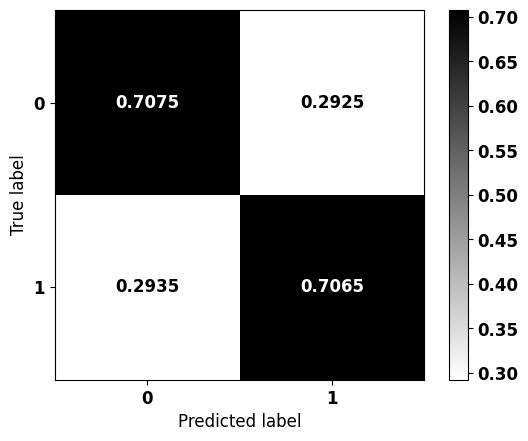


              precision    recall  f1-score   support

           0     0.6135    0.7075    0.6572      8302
           1     0.7859    0.7065    0.7441     12612

    accuracy                         0.7069     20914
   macro avg     0.6997    0.7070    0.7006     20914
weighted avg     0.7174    0.7069    0.7096     20914


1.738


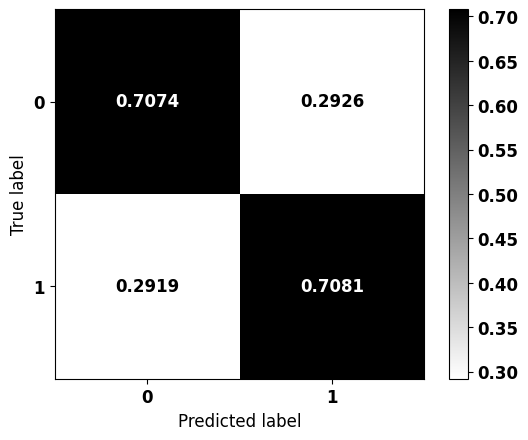


              precision    recall  f1-score   support

           0     0.6147    0.7074    0.6578      8302
           1     0.7862    0.7081    0.7451     12612

    accuracy                         0.7078     20914
   macro avg     0.7004    0.7077    0.7014     20914
weighted avg     0.7181    0.7078    0.7104     20914




In [ ]:
pesos = np.round(np.arange(1.6, 1.8, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.7, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 105,
 'max_depth': 10,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_samples': 0.8999999999999999}

In [ ]:
pesos = np.round(np.arange(1.6, 1.8, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

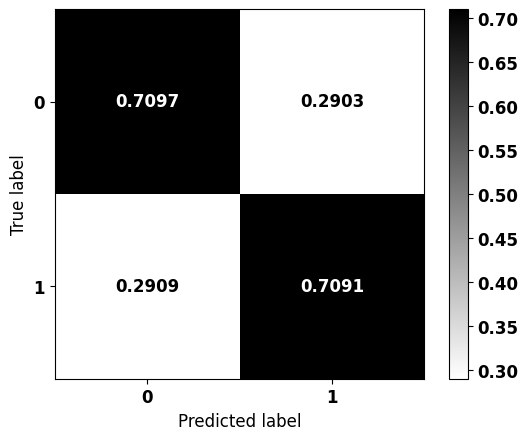


              precision    recall  f1-score   support

           0     0.6163    0.7097    0.6597      8302
           1     0.7877    0.7091    0.7463     12612

    accuracy                         0.7093     20914
   macro avg     0.7020    0.7094    0.7030     20914
weighted avg     0.7197    0.7093    0.7119     20914



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.691, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

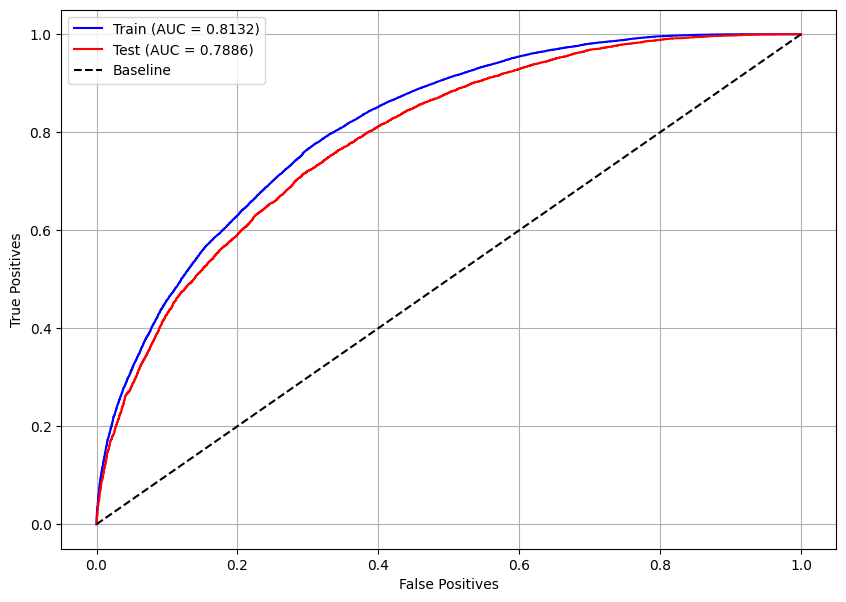

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

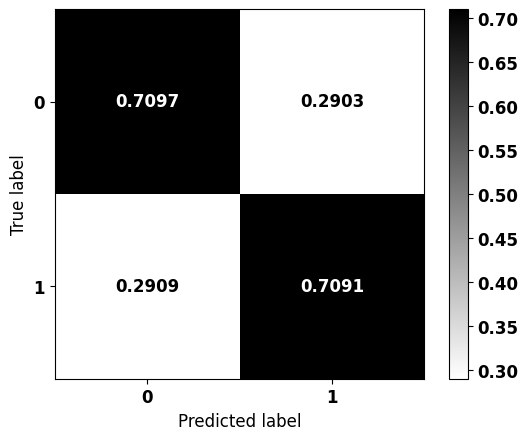


              precision    recall  f1-score   support

           0     0.6163    0.7097    0.6597      8302
           1     0.7877    0.7091    0.7463     12612

    accuracy                         0.7093     20914
   macro avg     0.7020    0.7094    0.7030     20914
weighted avg     0.7197    0.7093    0.7119     20914



In [32]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 105, 'max_depth': 10, 'min_samples_split': 8,
          'min_samples_leaf': 1, 'max_samples': 0.9}

params['random_state'] = seed
params['class_weight'] = {0:1.691, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

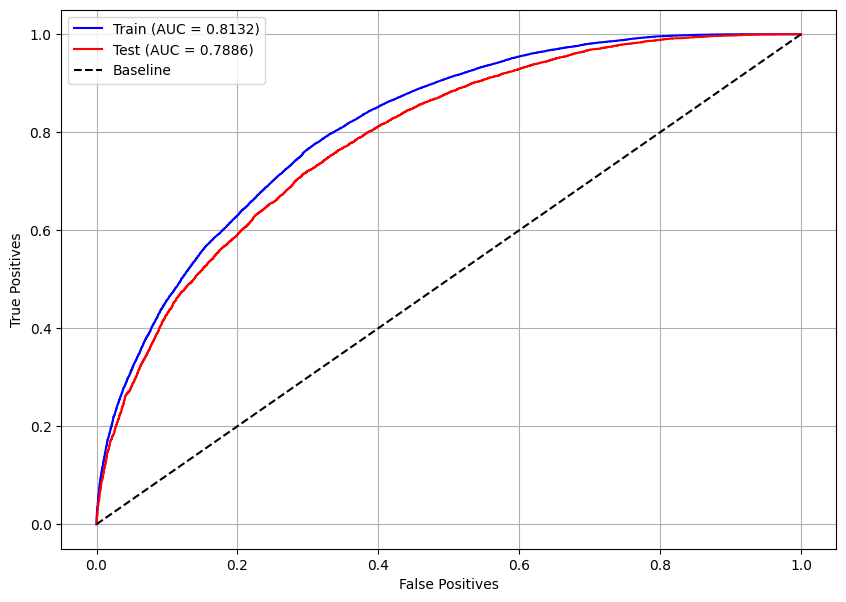

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

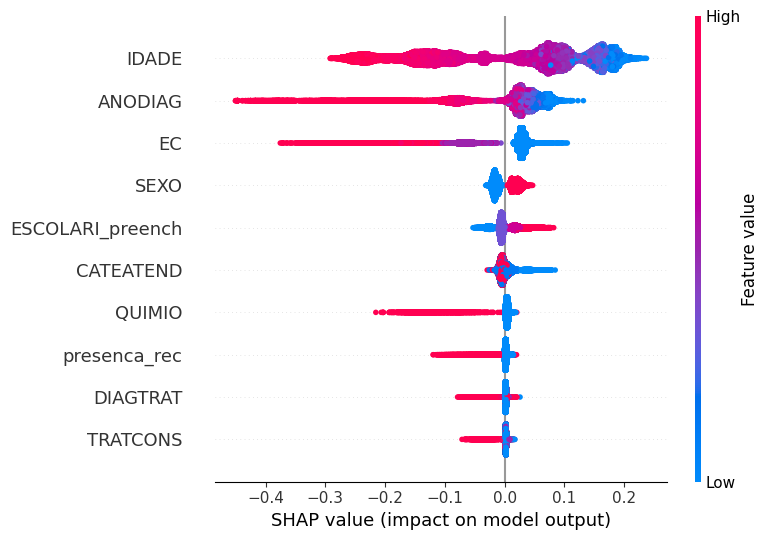

In [ ]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo base**

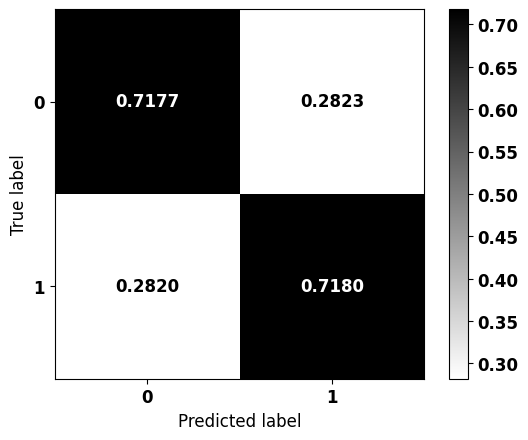


              precision    recall  f1-score   support

           0     0.6262    0.7177    0.6688      8302
           1     0.7944    0.7180    0.7542     12612

    accuracy                         0.7178     20914
   macro avg     0.7103    0.7178    0.7115     20914
weighted avg     0.7276    0.7178    0.7203     20914



In [33]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.5825,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

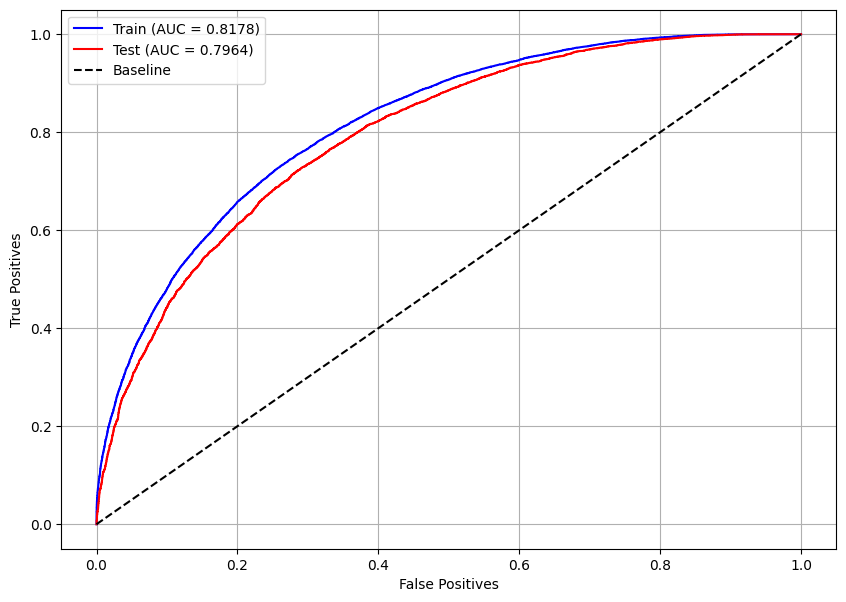

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

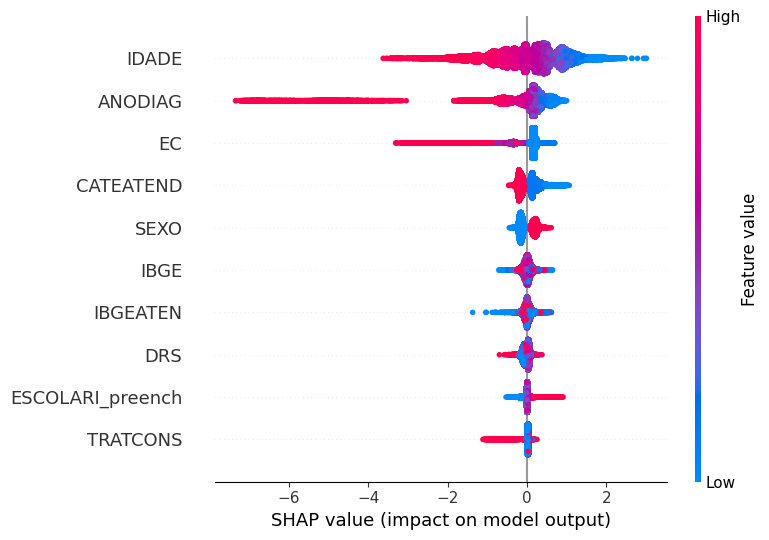

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=68, state=TrialState.COMPLETE, values=[0.7438677270516277], datetime_start=datetime.datetime(2023, 10, 17, 1, 47, 26, 896965), datetime_complete=datetime.datetime(2023, 10, 17, 1, 47, 43, 919800), params={'n_estimators': 124, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.1, 'min_child_weight': 3, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=68, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 124,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.57, 0.61, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

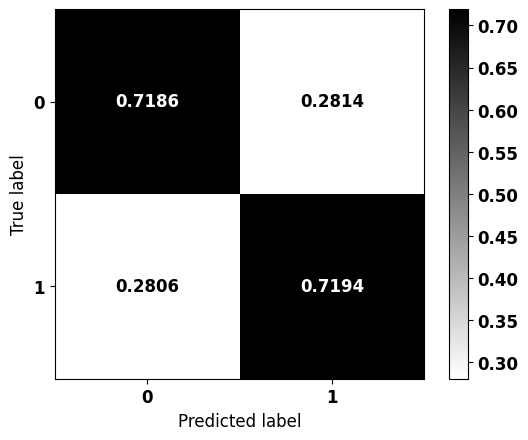


              precision    recall  f1-score   support

           0     0.6277    0.7186    0.6701      8302
           1     0.7952    0.7194    0.7554     12612

    accuracy                         0.7191     20914
   macro avg     0.7115    0.7190    0.7127     20914
weighted avg     0.7287    0.7191    0.7215     20914



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5749

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

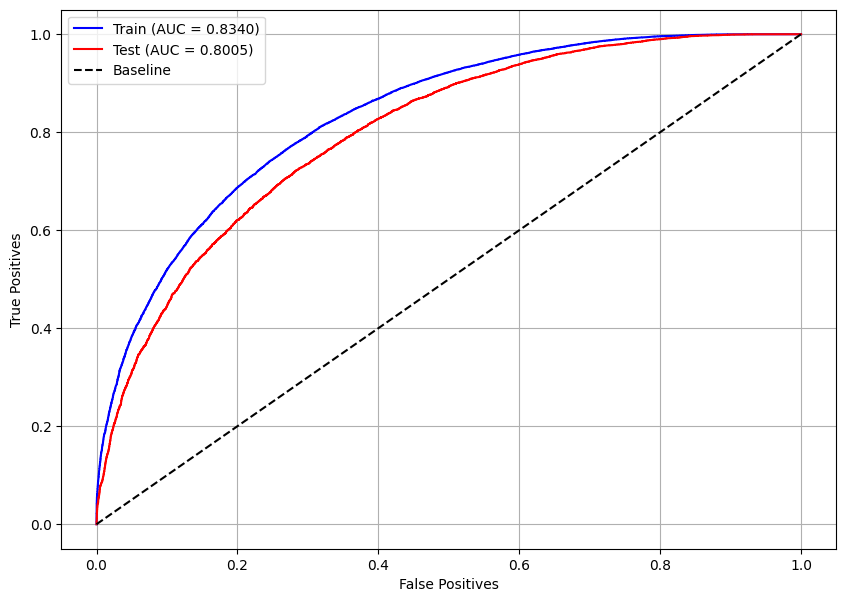

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 142,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.57, 0.61, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

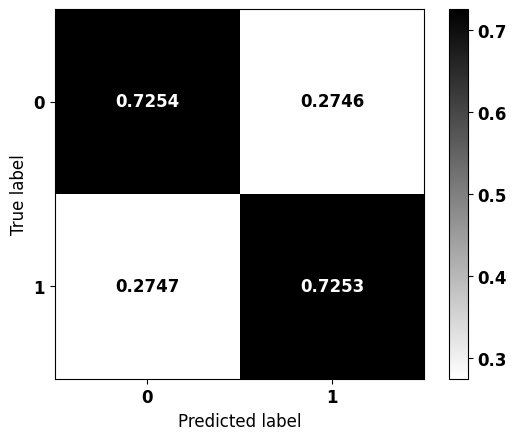


              precision    recall  f1-score   support

           0     0.6348    0.7254    0.6771      8302
           1     0.8005    0.7253    0.7611     12612

    accuracy                         0.7254     20914
   macro avg     0.7177    0.7254    0.7191     20914
weighted avg     0.7347    0.7254    0.7277     20914



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5796

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

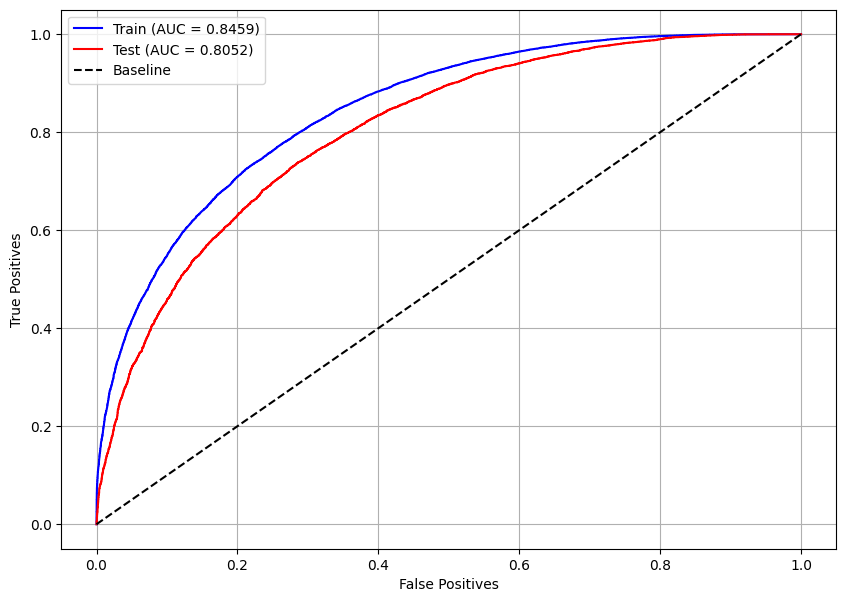

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 136,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.57, 0.61, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

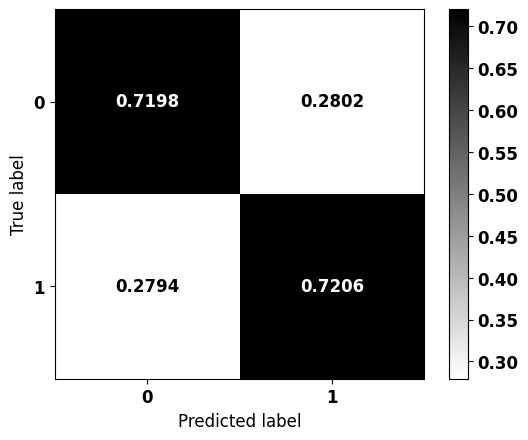


              precision    recall  f1-score   support

           0     0.6291    0.7198    0.6714      8302
           1     0.7962    0.7206    0.7565     12612

    accuracy                         0.7203     20914
   macro avg     0.7126    0.7202    0.7139     20914
weighted avg     0.7299    0.7203    0.7227     20914



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5788

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

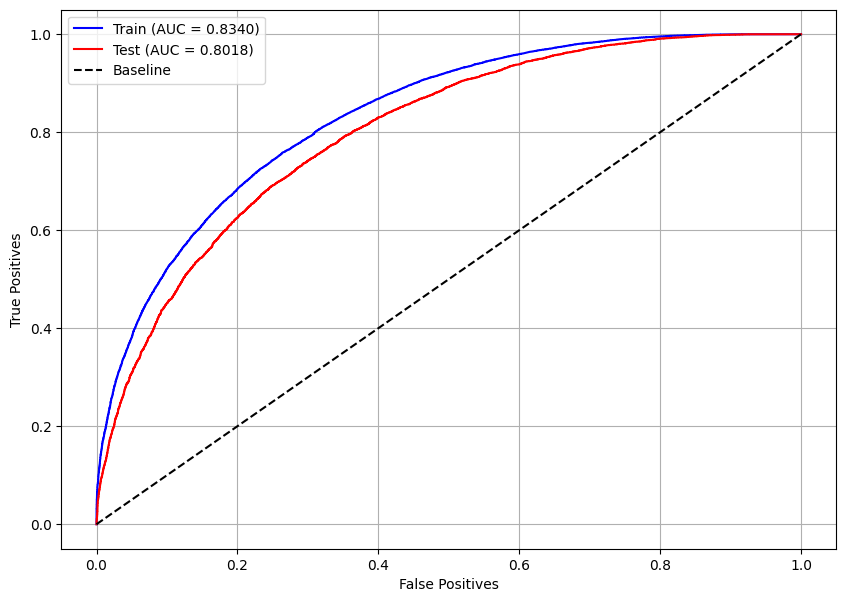

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

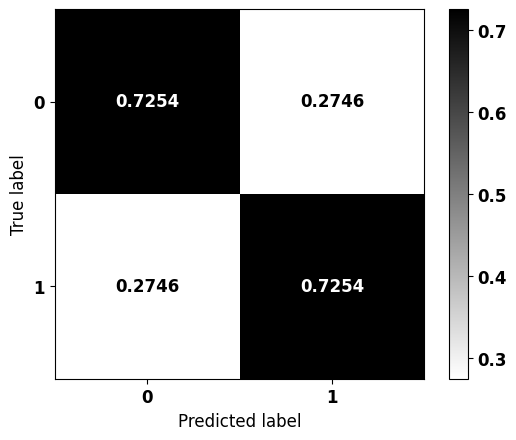


              precision    recall  f1-score   support

           0     0.6349    0.7254    0.6771      8302
           1     0.8005    0.7254    0.7611     12612

    accuracy                         0.7254     20914
   macro avg     0.7177    0.7254    0.7191     20914
weighted avg     0.7348    0.7254    0.7278     20914



In [34]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 142, 'max_depth': 6, 'learning_rate': 0.2,
          'gamma': 0.0, 'min_child_weight': 5, 'colsample_bytree': 0.7}

params['random_state'] = seed
params['scale_pos_weight'] = 0.5796

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

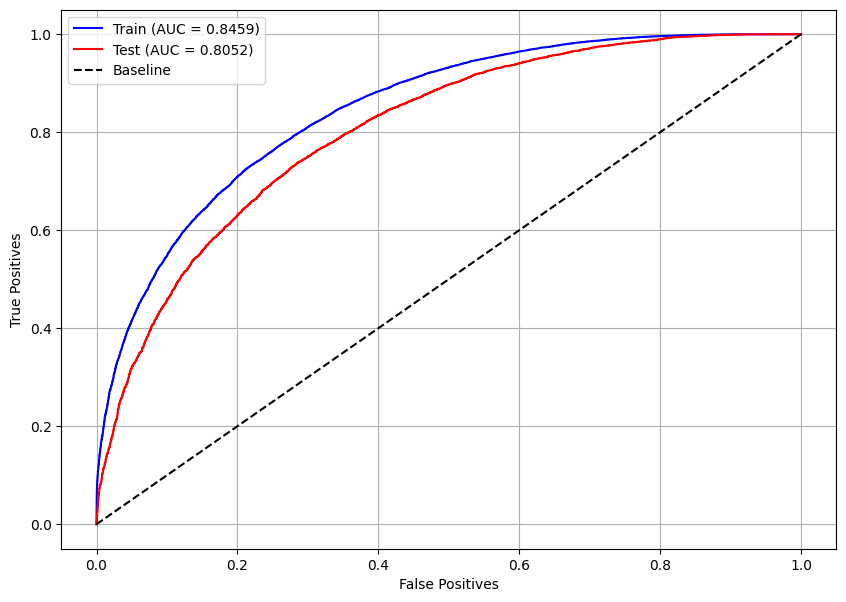

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

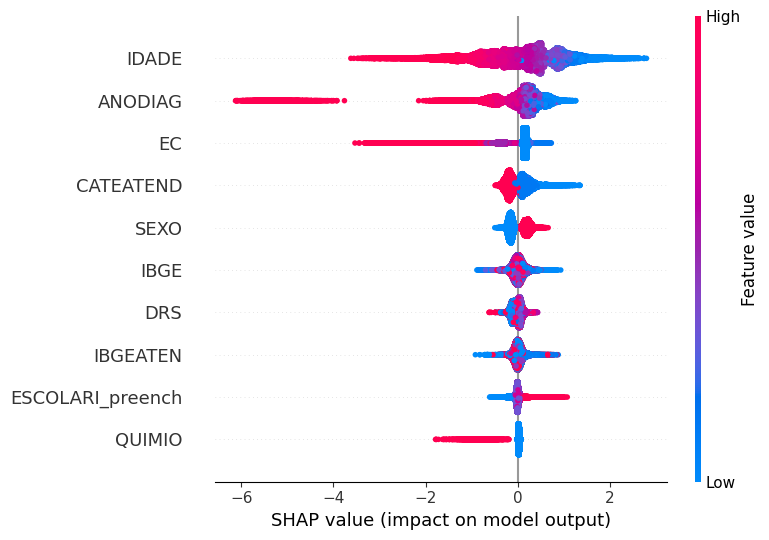

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo base**

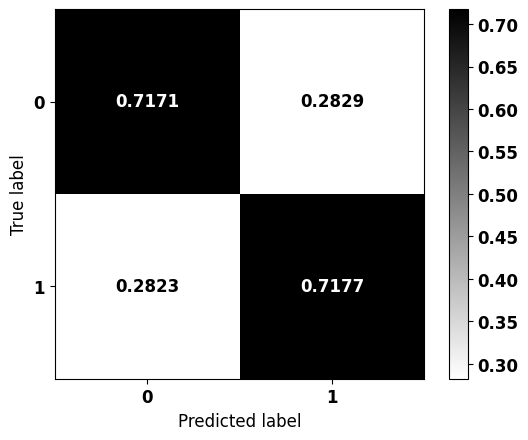


              precision    recall  f1-score   support

           0     0.6258    0.7171    0.6683      8302
           1     0.7940    0.7177    0.7539     12612

    accuracy                         0.7175     20914
   macro avg     0.7099    0.7174    0.7111     20914
weighted avg     0.7272    0.7175    0.7199     20914



In [38]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1.7, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

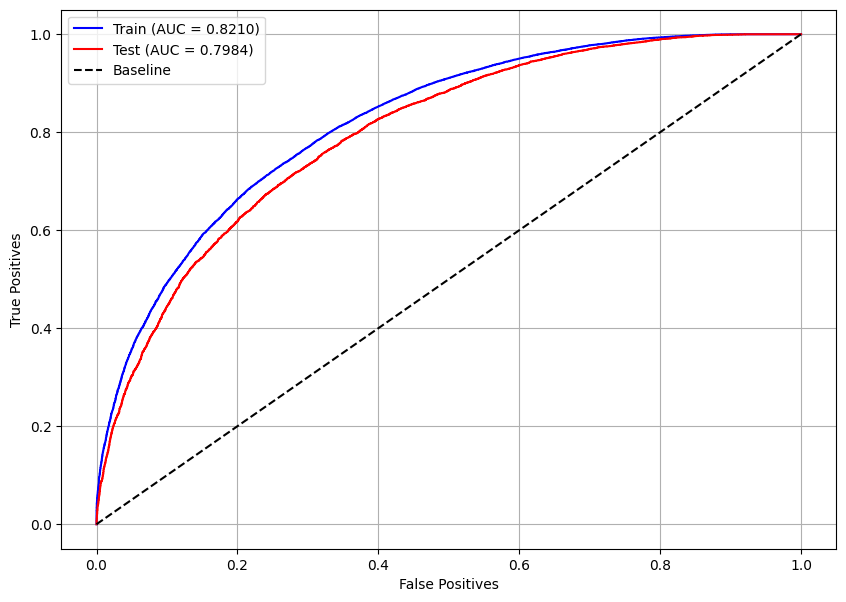

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

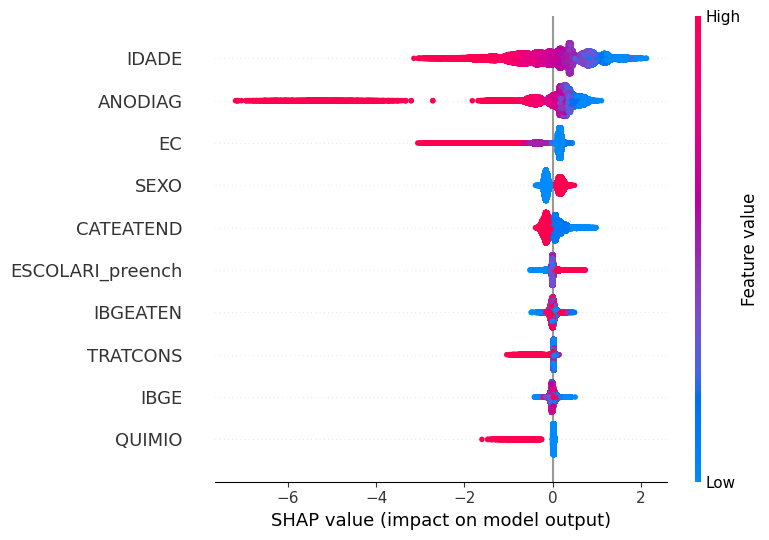

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [14]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=38, state=TrialState.COMPLETE, values=[0.7453021195422327], datetime_start=datetime.datetime(2023, 10, 17, 2, 59, 9, 290854), datetime_complete=datetime.datetime(2023, 10, 17, 2, 59, 35, 116361), params={'n_estimators': 148, 'max_depth': 9, 'learning_rate': 0.19, 'min_child_weight': 3, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=38, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 148,
 'max_depth': 9,
 'learning_rate': 0.19,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.7, 1.75, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

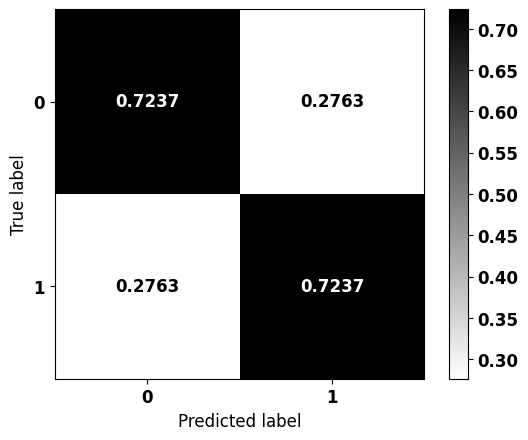


              precision    recall  f1-score   support

           0     0.6329    0.7237    0.6752      8302
           1     0.7991    0.7237    0.7595     12612

    accuracy                         0.7237     20914
   macro avg     0.7160    0.7237    0.7174     20914
weighted avg     0.7331    0.7237    0.7261     20914



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.7367, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

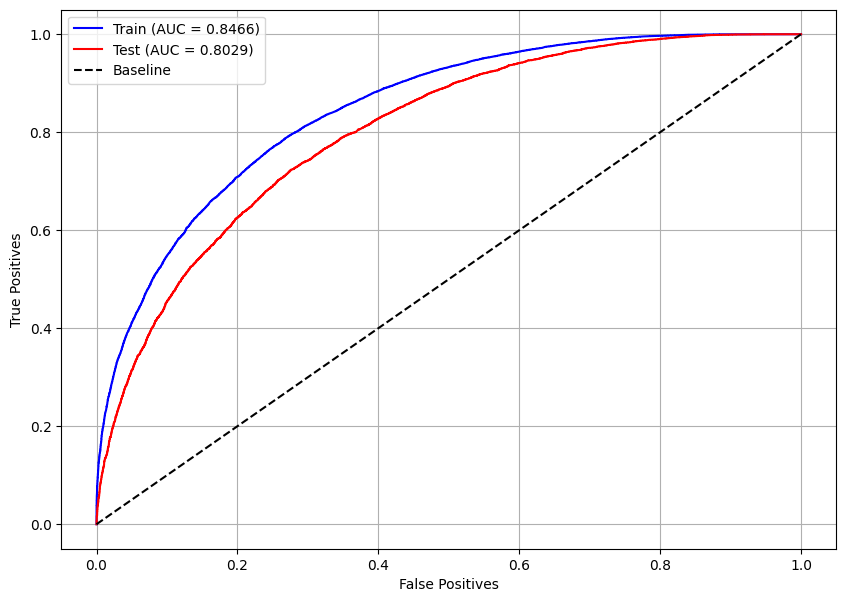

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [16]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 150,
 'max_depth': 8,
 'learning_rate': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(1.7, 1.75, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

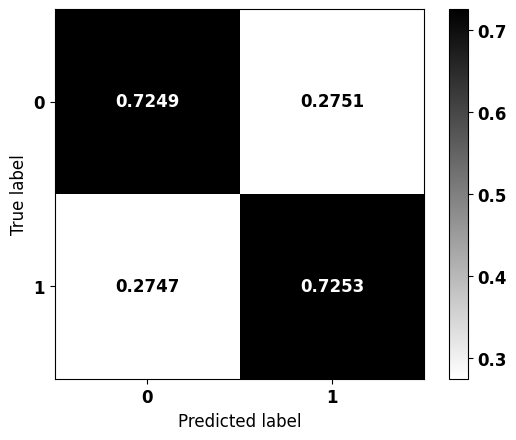


              precision    recall  f1-score   support

           0     0.6346    0.7249    0.6768      8302
           1     0.8002    0.7253    0.7609     12612

    accuracy                         0.7251     20914
   macro avg     0.7174    0.7251    0.7188     20914
weighted avg     0.7345    0.7251    0.7275     20914



In [18]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.71, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

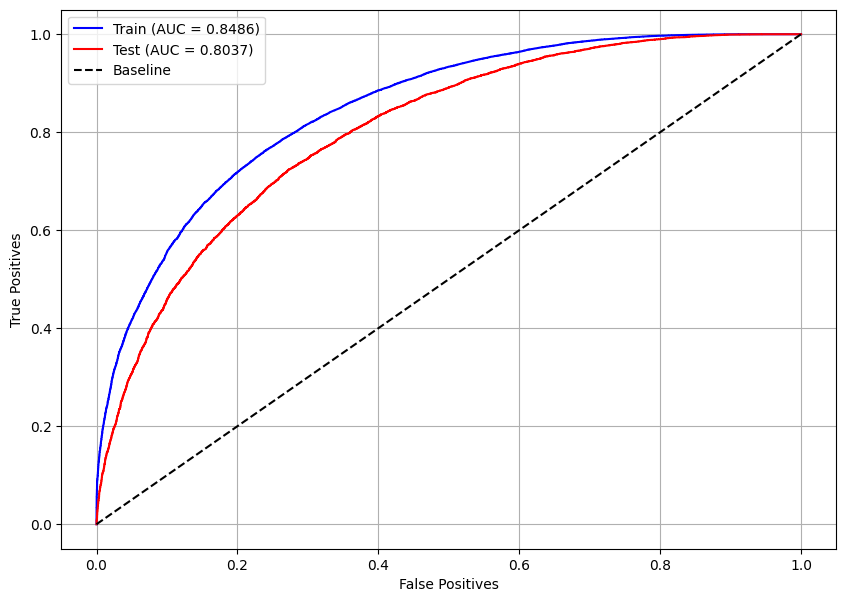

In [19]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [23]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 137,
 'max_depth': 10,
 'learning_rate': 0.19,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.7, 1.75, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

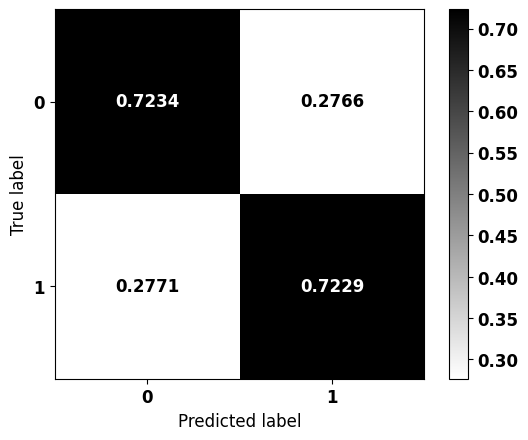


              precision    recall  f1-score   support

           0     0.6321    0.7234    0.6747      8302
           1     0.7988    0.7229    0.7590     12612

    accuracy                         0.7231     20914
   macro avg     0.7155    0.7232    0.7168     20914
weighted avg     0.7327    0.7231    0.7255     20914



In [25]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.7175, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

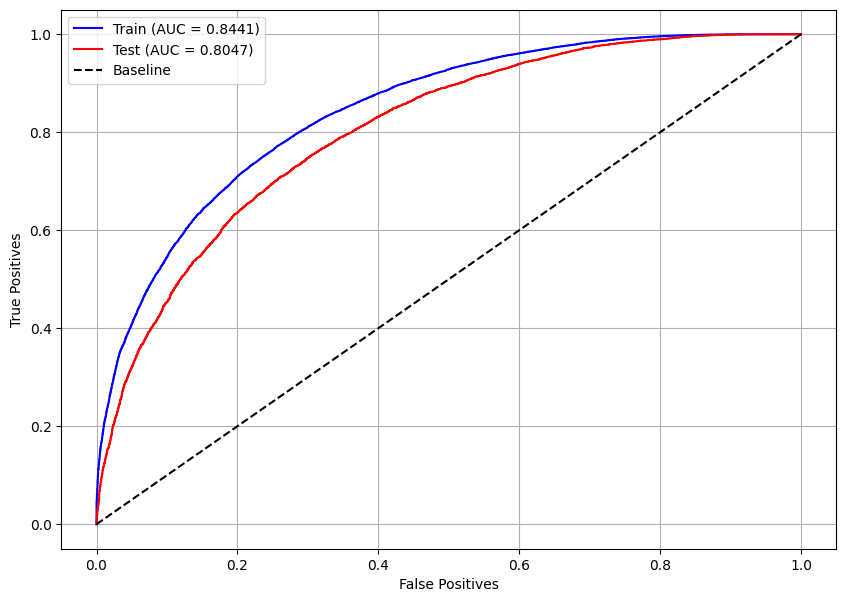

In [26]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

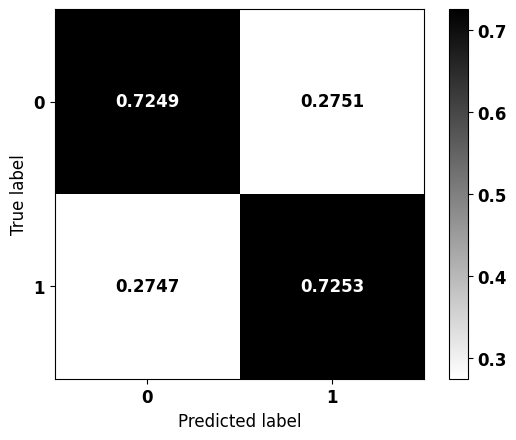


              precision    recall  f1-score   support

           0     0.6346    0.7249    0.6768      8302
           1     0.8002    0.7253    0.7609     12612

    accuracy                         0.7251     20914
   macro avg     0.7174    0.7251    0.7188     20914
weighted avg     0.7345    0.7251    0.7275     20914



In [27]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.2,
          'min_child_weight': 5, 'colsample_bytree': 0.7}

params['random_state'] = seed
params['class_weight'] = {0:1.71, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

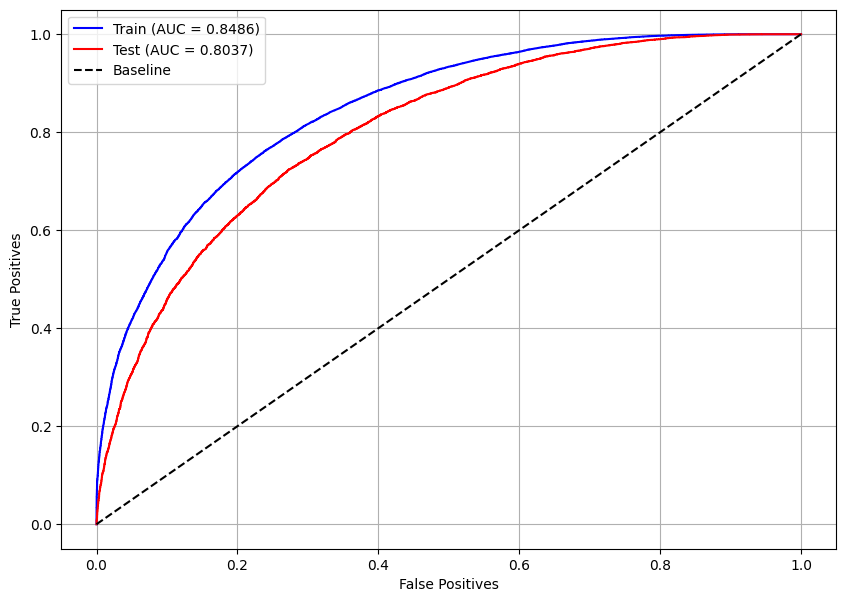

In [28]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


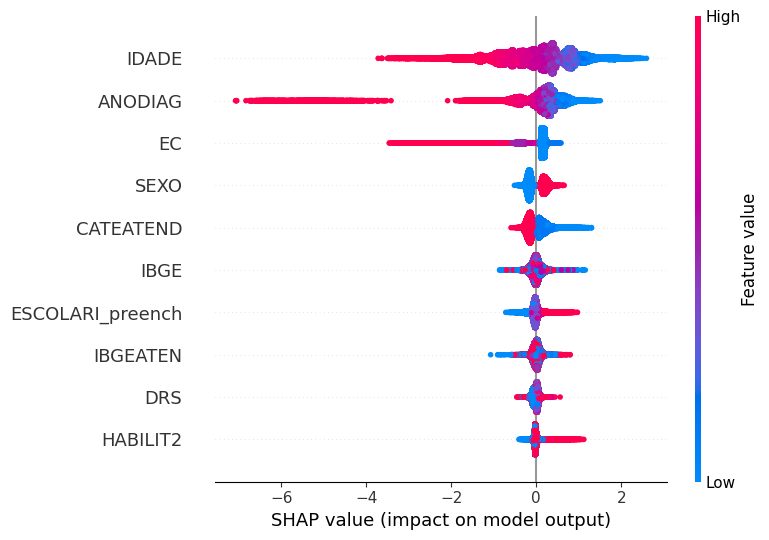

In [29]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [35]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7063, Optuna = 0.7093

Otimizado venceu


In [36]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7178, Optuna = 0.7254

Otimizado venceu


In [39]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7175, Optuna = 0.7251

Otimizado venceu


In [40]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.71, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.2, max_depth=8, min_child_weight=5,
               n_estimators=150, random_state=7, verbose=-1)

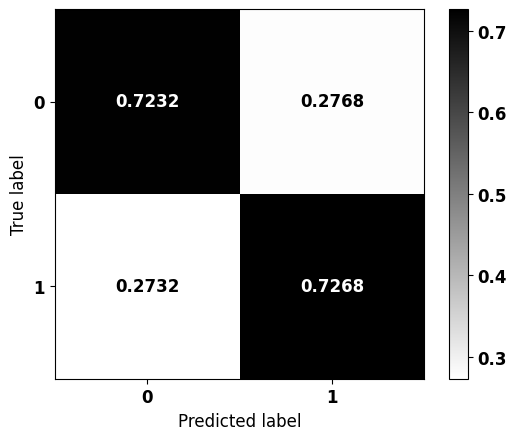


              precision    recall  f1-score   support

           0     0.6354    0.7232    0.6765      8302
           1     0.7996    0.7268    0.7615     12612

    accuracy                         0.7254     20914
   macro avg     0.7175    0.7250    0.7190     20914
weighted avg     0.7344    0.7254    0.7277     20914



In [45]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[#('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

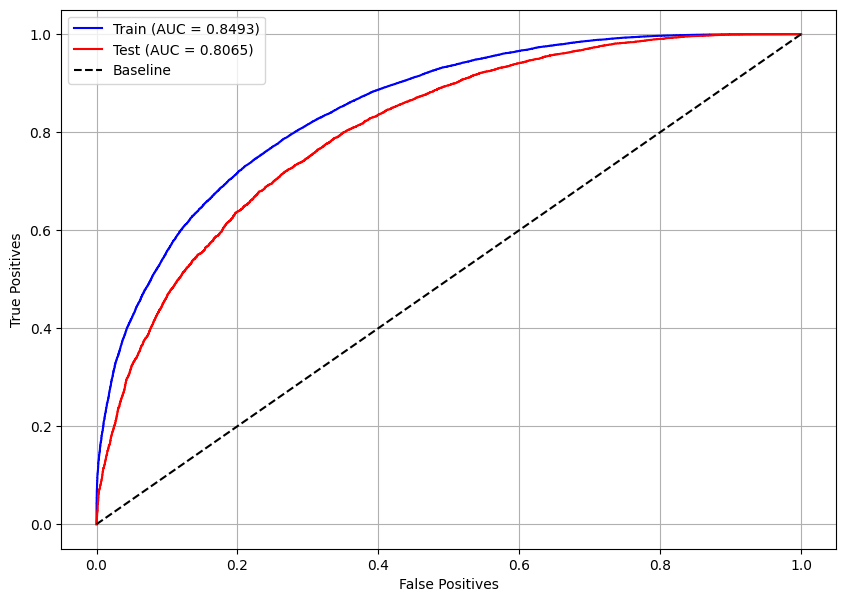

In [46]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [47]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=142, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


In [48]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano1',
 'sobrevida_ano3',
 'sobrevida_ano5']

### **Colorretal**

In [49]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


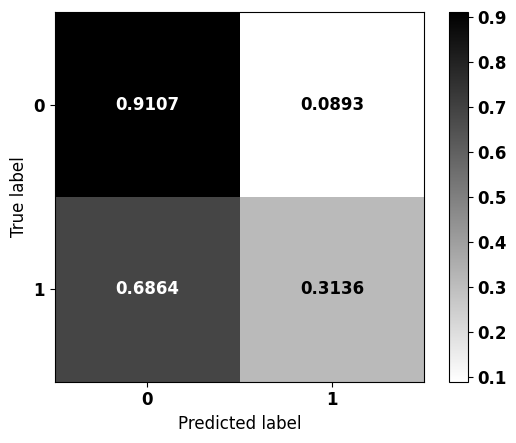


              precision    recall  f1-score   support

           0     0.6733    0.9107    0.7742     29592
           1     0.6934    0.3136    0.4319     19051

    accuracy                         0.6769     48643
   macro avg     0.6834    0.6122    0.6031     48643
weighted avg     0.6812    0.6769    0.6402     48643



In [50]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Pulmão**

In [51]:
df_pulmao = pd.read_csv('/content/pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


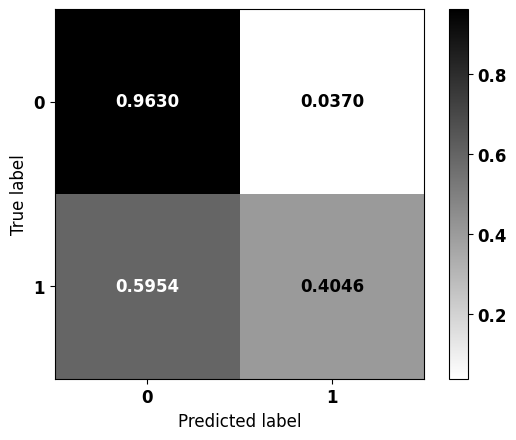


              precision    recall  f1-score   support

           0     0.9581    0.9630    0.9605     33335
           1     0.4362    0.4046    0.4198      2358

    accuracy                         0.9261     35693
   macro avg     0.6972    0.6838    0.6902     35693
weighted avg     0.9236    0.9261    0.9248     35693



In [52]:
pred_cruzada(df_pulmao, best, list_drop, lb, enc, norm)

### **Mama**

In [53]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


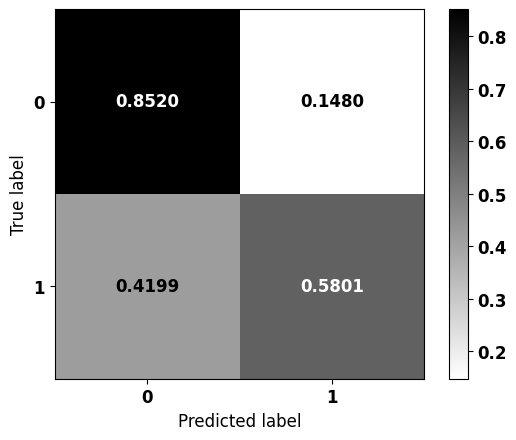


              precision    recall  f1-score   support

           0     0.5160    0.8520    0.6427     29453
           1     0.8818    0.5801    0.6998     56061

    accuracy                         0.6737     85514
   macro avg     0.6989    0.7161    0.6713     85514
weighted avg     0.7558    0.6737    0.6801     85514



In [54]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [55]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


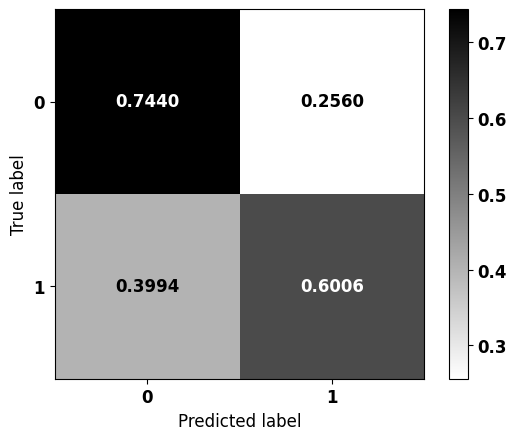


              precision    recall  f1-score   support

           0     0.7019    0.7440    0.7223     10641
           1     0.6500    0.6006    0.6243      8421

    accuracy                         0.6807     19062
   macro avg     0.6759    0.6723    0.6733     19062
weighted avg     0.6789    0.6807    0.6790     19062



In [56]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Próstata**

In [57]:
df_prostata = pd.read_csv('/content/prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


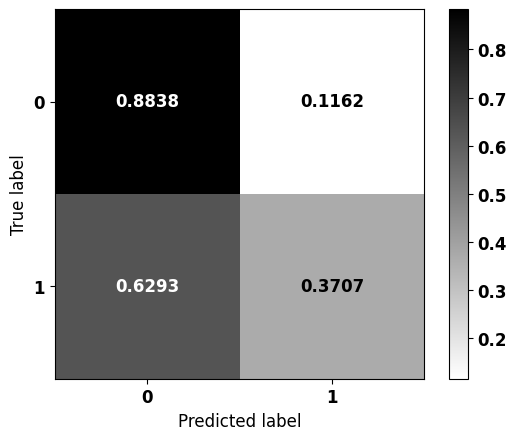


              precision    recall  f1-score   support

           0     0.3666    0.8838    0.5183     19989
           1     0.8856    0.3707    0.5226     48501

    accuracy                         0.5204     68490
   macro avg     0.6261    0.6273    0.5204     68490
weighted avg     0.7341    0.5204    0.5213     68490



In [58]:
pred_cruzada(df_prostata, best, list_drop, lb, enc, norm)